In [10]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
from scipy import spatial
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
import torchvision.models as models
import sys
sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')
from timm.utils import AverageMeter

In [11]:
class CFG:
    model_name = 'resnet152'
    input_size = 224
    batch_size = 64
    num_epochs = 8
    lr = 1e-4
    seed = 42

In [12]:
class DiffusionDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['filepath'])
        image = self.transform(image)
        prompt = row['prompt']
        return image, prompt

In [13]:
class DiffusionCollator:
    def __init__(self):
        self.st_model = SentenceTransformer(
            '/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2',
            device='cpu'
        )
    
    def __call__(self, batch):
        images, prompts = zip(*batch)
        images = torch.stack(images)
        prompt_embeddings = self.st_model.encode(
            prompts, 
            show_progress_bar=False, 
            convert_to_tensor=True
        )
        return images, prompt_embeddings

In [14]:
def get_dataloaders(
    trn_df,
    val_df,
    input_size,
    batch_size
):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    trn_dataset = DiffusionDataset(trn_df, transform)
    val_dataset = DiffusionDataset(val_df, transform)
    collator = DiffusionCollator()
    
    dataloaders = {}
    dataloaders['train'] = DataLoader(
        dataset=trn_dataset,
        shuffle=True,
        batch_size=batch_size,
        pin_memory=True,
        num_workers=2,
        drop_last=True,
        collate_fn=collator
    )
    dataloaders['val'] = DataLoader(
        dataset=val_dataset,
        shuffle=False,
        batch_size=batch_size,
        pin_memory=True,
        num_workers=2,
        drop_last=False,
        collate_fn=collator
    )
    return dataloaders

In [15]:
def cosine_similarity(y_trues, y_preds):
    return np.mean([
        1 - spatial.distance.cosine(y_true, y_pred) 
        for y_true, y_pred in zip(y_trues, y_preds)
    ])

In [21]:
#def load_model(model, model_name):
#    model_path = '/kaggle/input/resnet152-model/resnet152.pth'
#    if os.path.exists(model_path):
#        model.load_state_dict(torch.load('/kaggle/input/resnet152-model/resnet152.pth'))
 #       print(f"Loaded model from {model_path}")
#    else:
#        print("No pre-trained model found. Training from scratch.")
#    return model

In [16]:
def train(
    trn_df,
    val_df,
    model_name,
    input_size,
    batch_size,
    num_epochs,
    lr,
    start_epoch=0  # Add start_epoch parameter
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataloaders = get_dataloaders(
        trn_df,
        val_df,
        input_size,
        batch_size
    )

    model = models.resnet152(pretrained=True)
    # Modify the last layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 384)

    # Load saved model if exists
    model = load_model(model, model_name)

    # Freeze all layers except the last layer
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    ttl_iters = num_epochs * len(dataloaders['train'])
    scheduler = CosineAnnealingLR(optimizer, T_max=ttl_iters, eta_min=1e-6)
    criterion = nn.MSELoss()
    
    best_score = -1.0

    for epoch in range(num_epochs):
        train_meters = {
            'loss': AverageMeter(),
            'cos': AverageMeter(),
        }
        model.train()
        for X, y in tqdm(dataloaders['train'], leave=False):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            X_out = model(X)
            loss = criterion(X_out, y)
            loss.backward()

            optimizer.step()
            scheduler.step()

            trn_loss = loss.item()
            trn_cos = cosine_similarity(
                X_out.detach().cpu().numpy(), 
                y.detach().cpu().numpy()
            )

            train_meters['loss'].update(trn_loss, n=X.size(0))
            train_meters['cos'].update(trn_cos, n=X.size(0))

        print('Epoch {:d} / trn/loss={:.4f}, trn/cos={:.4f}'.format(
            epoch + 1,
            train_meters['loss'].avg,
            train_meters['cos'].avg))

        val_meters = {
            'loss': AverageMeter(),
            'cos': AverageMeter(),
        }
        model.eval()
        for X, y in tqdm(dataloaders['val'], leave=False):
            X, y = X.to(device), y.to(device)

            with torch.no_grad():
                X_out = model(X)
                loss = criterion(X_out, y)

                val_loss = loss.item()
                val_cos = cosine_similarity(
                    X_out.detach().cpu().numpy(), 
                    y.detach().cpu().numpy()
                )

            val_meters['loss'].update(val_loss, n=X.size(0))
            val_meters['cos'].update(val_cos, n=X.size(0))

        print('Epoch {:d} / val/loss={:.4f}, val/cos={:.4f}'.format(
            epoch + 1,
            val_meters['loss'].avg,
            val_meters['cos'].avg))
        
        if val_meters['cos'].avg > best_score:
            best_score = val_meters['cos'].avg
            torch.save(model.state_dict(), f'{model_name}.pth')
    

In [17]:
df = pd.read_csv('/kaggle/input/diffusiondb-data-cleansing/diffusiondb.csv')
trn_df, val_df = train_test_split(df, test_size=0.1, random_state=CFG.seed)

In [24]:
train(trn_df, val_df, CFG.model_name, CFG.input_size, CFG.batch_size, CFG.num_epochs, CFG.lr, start_epoch=CFG.num_epochs)

Loaded model from /kaggle/input/resnet152-model/resnet152.pth


  0%|          | 0/2170 [00:00<?, ?it/s]

Epoch 1 / trn/loss=0.0029, trn/cos=0.3167


  0%|          | 0/242 [00:00<?, ?it/s]

Epoch 1 / val/loss=0.0027, val/cos=0.3451


  0%|          | 0/2170 [00:00<?, ?it/s]

Epoch 2 / trn/loss=0.0025, trn/cos=0.3640


  0%|          | 0/242 [00:00<?, ?it/s]

Epoch 2 / val/loss=0.0024, val/cos=0.3755


  0%|          | 0/2170 [00:00<?, ?it/s]

Epoch 3 / trn/loss=0.0023, trn/cos=0.3994


  0%|          | 0/242 [00:00<?, ?it/s]

Epoch 3 / val/loss=0.0023, val/cos=0.4064


  0%|          | 0/2170 [00:00<?, ?it/s]

Epoch 4 / trn/loss=0.0022, trn/cos=0.4258


  0%|          | 0/242 [00:00<?, ?it/s]

Epoch 4 / val/loss=0.0022, val/cos=0.4250


  0%|          | 0/2170 [00:00<?, ?it/s]

Epoch 5 / trn/loss=0.0021, trn/cos=0.4422


  0%|          | 0/242 [00:00<?, ?it/s]

Epoch 5 / val/loss=0.0022, val/cos=0.4339


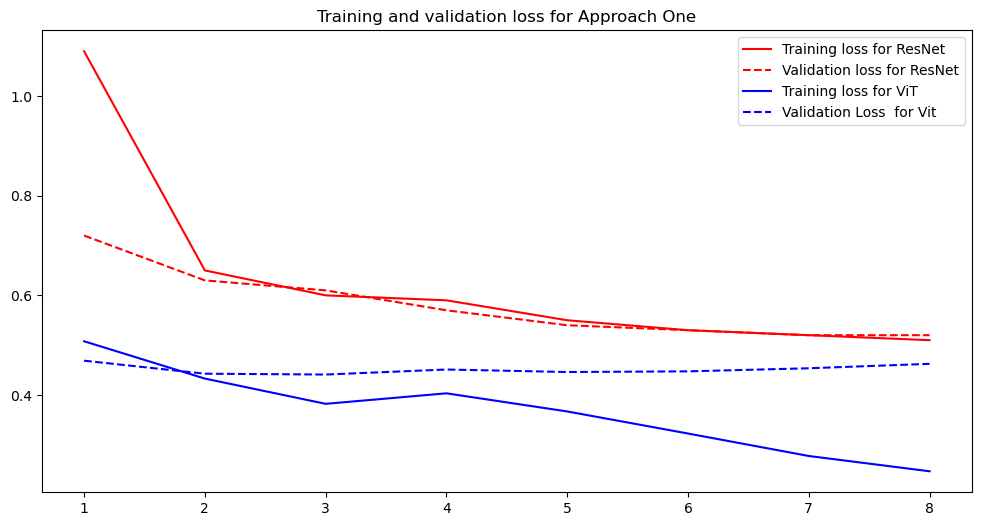

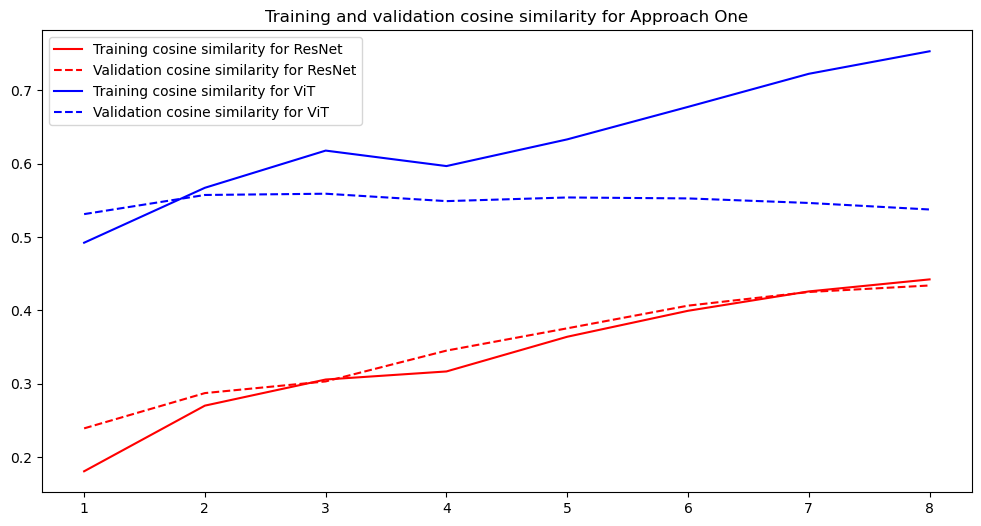

In [6]:
import matplotlib.pyplot as plt
train_loss = [1.09, 0.65, 0.60, 0.59, 0.55, 0.53, 0.52, 0.51]
train_cos = [0.1806, 0.2701, 0.3057, 0.3167, 0.3640, 0.3994, 0.4258, 0.4422]
val_loss = [0.72, 0.63, 0.61, 0.57, 0.54, 0.53, 0.52, 0.52]
val_cos = [0.2391, 0.2872, 0.3031, 0.3451, 0.3755, 0.4064, 0.4250, 0.4339]

y1 = [0.5078, 0.4329, 0.3822, 0.4033, 0.3669,0.3226, 0.2775, 0.2468]
y2 = [0.4922, 0.5671, 0.6178, 0.5967, 0.6331, 0.6774, 0.7225, 0.7532]
z1 = [0.4688, 0.4427, 0.4410, 0.4511, 0.4461, 0.4474, 0.4536, 0.4625]
z2 = [0.5312, 0.5573, 0.5590, 0.5489, 0.5539, 0.5526, 0.5464, 0.5375]

epochs = range(1, len(y1) + 1)

# plot loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'r', label='Training loss for ResNet')
plt.plot(epochs, val_loss, 'r--', label='Validation loss for ResNet')
plt.plot(epochs, y1, 'b', label='Training loss for ViT')
plt.plot(epochs, z1, 'b--', label='Validation Loss  for Vit')
plt.title('Training and validation loss for Approach One')
plt.legend()
plt.show()

# plot cosine similarity
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_cos, 'r', label='Training cosine similarity for ResNet')
plt.plot(epochs, val_cos, 'r--', label='Validation cosine similarity for ResNet')
plt.plot(epochs, y2, 'b', label='Training cosine similarity for ViT')
plt.plot(epochs, z2, 'b--', label='Validation cosine similarity for ViT')
plt.title('Training and validation cosine similarity for Approach One')
plt.legend()
plt.show()

In [22]:
def test(test_df, model_name, input_size, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the trained model
    model = models.resnet152()
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 384)
    model.load_state_dict(torch.load('/kaggle/input/resnet152-new/resnet152_updated.pth'))
    model.to(device)
    model.eval()

    # Create test dataloader
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    test_dataset = DiffusionDataset(test_df, transform)
    collator = DiffusionCollator()
    test_dataloader = DataLoader(
        dataset=test_dataset,
        shuffle=False,
        batch_size=batch_size,
        pin_memory=True,
        num_workers=2,
        drop_last=False,
        collate_fn=collator
    )

    # Initialize metrics
    criterion = nn.MSELoss()
    test_meters = {'loss': AverageMeter(), 'cos': AverageMeter()}

    # Run the model on the test set and compute metrics
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            X_out = model(X)
            loss = criterion(X_out, y)

            test_loss = loss.item()
            test_cos = cosine_similarity(
                X_out.detach().cpu().numpy(), 
                y.detach().cpu().numpy()
            )

        test_meters['loss'].update(test_loss, n=X.size(0))
        test_meters['cos'].update(test_cos, n=X.size(0))

    print('Test loss: {:.4f}, Test cosine similarity: {:.4f}'.format(
        test_meters['loss'].avg,
        test_meters['cos'].avg
    ))

In [23]:
test_df = pd.read_csv('/kaggle/input/test-dataset/test.csv') 
test(test_df, CFG.model_name, CFG.input_size, CFG.batch_size)

  0%|          | 0/235 [00:00<?, ?it/s]

Test loss: 0.0022, Test cosine similarity: 0.4392
